# Factorisation-aware matrix element emulator

This is a quickstart notebook that will take you through the necessary steps to reproduce the method described in the paper.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# comment this out if you want to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from fame.phase_space import phasespace
from fame.utilities import utility_functions, tests
from fame.data_generation import cs_dipole, model_inputs
from fame.model.dipole_model import DipoleModel

# Generate phase-space points using RAMBO with FastJet clustering

In [3]:
w = 1000 # sqrt(s)
num_jets = 4 # number of final state jets
train_points = 500000
test_points = 100000
num_points = train_points + test_points # number of phase-space points to generate
y_global_cut = 0.001 # global phase-space cut
num_cores = 16 # number of cores for parallel clustering of jets

In [4]:
# clusters points using e+e- kt algorithm
X = phasespace.generate_generic(
    num_jets,
    num_points,
    w,
    y_global_cut,
    num_cores
)

Phase-space points:   0%|          | 0/600000 [00:00<?, ?it/s]

######## Finished generating generic phase-space points #########


Phase-space points are structured in the following way:
1. First and seconds rows are e+ and e-
2. Third row is quark
3. Fourth row is anti-quark
4. Fifth and onwards are gluons

This helps us to keep consistency between the inputs we calculate.

In [5]:
X[0]

array([[ 500.        ,    0.        ,    0.        ,  500.        ],
       [ 500.        ,    0.        ,    0.        , -500.        ],
       [ 351.17310502,  147.05877403,  -72.31030558,  310.5921544 ],
       [ 364.99573015, -333.08502821,   36.63115041, -144.68726907],
       [ 101.65025089,   20.47226992,   -1.4647162 ,  -99.55658831],
       [ 182.18091394,  165.55398427,   37.14387138,  -66.34829702]])

# Evaluate phase-space points using matrix element provider
## here we use NJet but others are available

In [6]:
njet_data, njet_order = utility_functions.run_njet(num_jets)

Check 'njet_data' has the correct incoming and outgoing particles.

'inc': [11, -11] -> e+ e-

'out': [1, -1, 21, 21] -> ddxgg

In [7]:
print(njet_data[0][1])

[{'born': 0, 'inc': [11, -11], 'loop': 0, 'mcn': 1, 'name': 'eeddxGG', 'out': [1, -1, 21, 21]}]


In [8]:
Y = utility_functions.generate_LO_njet([x.tolist() for x in X], njet_data)

-------- channel eeddxGG -------- (600000 points)


  0%|          | 0/600000 [00:00<?, ?it/s]

# Split data into training and testing sets

In [9]:
X_train, X_test = X[:train_points], X[train_points:]
Y_train, Y_test = Y[:train_points], Y[train_points:]

Check magnitude of training and testing datasets are similar.

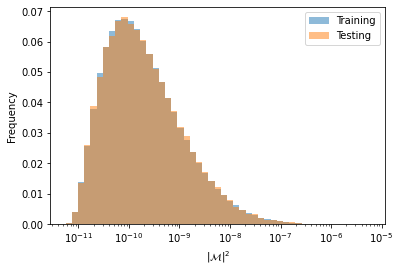

In [10]:
bins = np.logspace(np.log10(np.min(Y_train)), np.log10(np.max(Y_train)), 50)
plt.figure()
plt.hist(Y_train, bins, weights=np.ones(train_points) / train_points, alpha=0.5, label='Training')
plt.hist(Y_test, bins, weights=np.ones(test_points) / test_points, alpha=0.5, label='Testing')
plt.legend()
plt.xscale("log")
plt.xlabel(r"$|\mathcal{M}|^{2}$")
plt.ylabel("Frequency")
plt.show()

# Generate neural network inputs

## Calculate dipoles and recoil factors

First need to get relevant permutations where each permutation is in the form $(i, j, k)$

$i$ = emitter,
$j$ = emitted,
$k$ = spectator

Partons are numbered from $(1, ..., n_{j})$ where 1 = $q$, 2 = $\bar{q}$, and everything 3+ = $g$, like the phase-space points.

For example permutation $(2, 4, 1)$ would mean the anti-quark emits a gluon and the quark is the spectator.

**For each permutation we have a corresponding dipole and recoil factor.**

In [11]:
relevant_permutations = model_inputs.get_relevant_permutations(num_jets)
tests.check_relevant_permutations(relevant_permutations, num_jets)

In [12]:
relevant_permutations

[(1, 3, 2),
 (1, 3, 4),
 (1, 4, 2),
 (1, 4, 3),
 (2, 3, 1),
 (2, 3, 4),
 (2, 4, 1),
 (2, 4, 3),
 (3, 4, 1),
 (3, 4, 2)]

In [13]:
# initialise classes that will generate inputs
CS = cs_dipole.CS_dipole(mode='gluon')
relevant_inputs = model_inputs.ModelInputsGenerator(relevant_permutations, CS)

If there are two or more gluons in the final state we need to account for spin-correlation effects that have been averaged out in the spin-averaged Catani-Seymour dipoles.

**For each pair of gluons in the final state, $(i, j)$, there are $sin(2\phi_{ij})$ and $cos(2\phi_{ij})$ terms.**

**The total set of dipoles is therefore the Catani-Seymour dipoles and the spin-correlation terms.**

In [14]:
# calculate model inputs
if num_jets > 3:
    # extra spin-correlation terms
    train_phi_terms = model_inputs.calculate_cs_phis(p=X_train, num_jets=num_jets, cast=False)
    tests.check_phi_terms(train_phi_terms, num_jets)
    
    # Catani-Seymour dipoles and recoil factors
    # concatenate phi terms with Catani-Seymour dipoles
    train_dipoles, train_ys = relevant_inputs.calculate_inputs(
        p_array=X_train,
        to_concat=[*train_phi_terms]
    )
    
    tests.check_recoil_factors(train_ys, num_jets)
    tests.check_all_dipoles(train_dipoles, num_jets)
else:
    # no phi terms for 3-jet case
    train_dipoles, train_ys = relevant_inputs.calculate_inputs(p_array=X_train)
    tests.check_all_dipoles(train_dipoles, num_jets)

In [15]:
# set scales of problem
pred_scale = np.min(Y_train)
dipole_scale = np.mean(train_dipoles)
coef_scale = pred_scale / dipole_scale

In [16]:
print(f"X shape = {X_train.shape}, Y shape = {Y_train.shape}, dipoles shape = {train_dipoles.shape}, ys shape = {train_ys.shape}")
print(f"pred_scale = {pred_scale}, dipole_scale = {dipole_scale}, coef_scale = {coef_scale}")

X shape = (500000, 6, 4), Y shape = (500000,), dipoles shape = (500000, 12), ys shape = (500000, 10)
pred_scale = 5.5714033998247135e-12, dipole_scale = 0.0006503360422056045, coef_scale = 8.566960829864797e-09


Now we have all the inputs generated we feed it to our emulator.

# Constructing neural network

## Define neural network hyperparameters

In [17]:
batch_size = 4096
lr = 0.001
# min_delta for EarlyStopping, should go smaller for lower multiplicity as higher accuracy there
min_delta = 1E-6
# J is tuned manually such that f_pen << mse
J = 1E6

## Initialise class for building dipole NN

In [18]:
dipole_model = DipoleModel(
    num_jets=num_jets,
    permutations=relevant_permutations,
    X=X_train,
    Y=Y_train,
    recoil_factors=train_ys,
    dipoles=train_dipoles,
    pred_scale=pred_scale,
    coef_scale=coef_scale,
    J=J
)

## Preprocesssing inputs involves standardising inputs and outputs

In [19]:
dipole_model.preprocess_inputs()

All scalers can be accessed through the DipoleModel class.

In [20]:
dipole_model.y_scaler.variables

[<tf.Variable 'mean:0' shape=(1,) dtype=float32, numpy=array([4.2759204], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(1,) dtype=float32, numpy=array([3.0926394], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=500000>]

## Building model: create densely connected neural network with custom loss

In [21]:
dipole_model.build_model()

In [22]:
dipole_model.model.summary()

Model: "dipole_4_jets"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 4, 4)         9           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16)           0           normalization[0][0]              
______________________________________________________________________________________

# Train model

The following wrapper functions will train the network until the desired min_delta is reached in the validation loss.

It is possible to terminate training prematurely by interrupting the Jupyter kernel. The model will have the most up-to-date weights.

In [23]:
history = dipole_model.train_model(
    checkpoint_path=None,
    batch_size=batch_size,
    learning_rate=lr,
    min_delta=min_delta
)

Epoch 1/10000
98/98 [==============================] - 5s 42ms/step - loss: 0.3307 - mse: 0.3307 - f_pen: 7.0067e-07 - val_loss: 0.0653 - val_mse: 0.0653 - val_f_pen: 5.9105e-07
Epoch 2/10000
98/98 [==============================] - 4s 38ms/step - loss: 0.0362 - mse: 0.0362 - f_pen: 5.3295e-07 - val_loss: 0.0192 - val_mse: 0.0192 - val_f_pen: 5.1451e-07
Epoch 3/10000
98/98 [==============================] - 4s 39ms/step - loss: 0.0131 - mse: 0.0131 - f_pen: 5.0905e-07 - val_loss: 0.0093 - val_mse: 0.0093 - val_f_pen: 5.0474e-07
Epoch 4/10000
98/98 [==============================] - 4s 38ms/step - loss: 0.0074 - mse: 0.0074 - f_pen: 5.0117e-07 - val_loss: 0.0060 - val_mse: 0.0060 - val_f_pen: 4.9823e-07
Epoch 5/10000
98/98 [==============================] - 4s 39ms/step - loss: 0.0051 - mse: 0.0051 - f_pen: 5.0083e-07 - val_loss: 0.0045 - val_mse: 0.0045 - val_f_pen: 5.0004e-07
Epoch 6/10000
98/98 [==============================] - 4s 38ms/step - loss: 0.0039 - mse: 0.0039 - f_pen: 5.02

98/98 [==============================] - 4s 38ms/step - loss: 5.4647e-04 - mse: 5.4580e-04 - f_pen: 6.6515e-07 - val_loss: 2.3194e-04 - val_mse: 2.3127e-04 - val_f_pen: 6.7479e-07
Epoch 45/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.5979e-04 - mse: 3.5912e-04 - f_pen: 6.7103e-07 - val_loss: 2.5975e-04 - val_mse: 2.5907e-04 - val_f_pen: 6.7920e-07
Epoch 46/10000
98/98 [==============================] - 4s 37ms/step - loss: 4.2194e-04 - mse: 4.2127e-04 - f_pen: 6.7597e-07 - val_loss: 2.5337e-04 - val_mse: 2.5270e-04 - val_f_pen: 6.7551e-07
Epoch 47/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.8097e-04 - mse: 3.8029e-04 - f_pen: 6.7990e-07 - val_loss: 6.4405e-04 - val_mse: 6.4335e-04 - val_f_pen: 6.9850e-07
Epoch 48/10000
98/98 [==============================] - 4s 37ms/step - loss: 9.1292e-04 - mse: 9.1223e-04 - f_pen: 6.8792e-07 - val_loss: 2.1735e-04 - val_mse: 2.1665e-04 - val_f_pen: 6.9731e-07
Epoch 49/10000
98/98 [==================

98/98 [==============================] - 4s 37ms/step - loss: 1.8634e-04 - mse: 1.8542e-04 - f_pen: 9.1311e-07 - val_loss: 1.0823e-04 - val_mse: 1.0731e-04 - val_f_pen: 9.2320e-07
Epoch 87/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.7206e-04 - mse: 3.7114e-04 - f_pen: 9.2029e-07 - val_loss: 9.8471e-05 - val_mse: 9.7542e-05 - val_f_pen: 9.2840e-07
Epoch 88/10000
98/98 [==============================] - 4s 38ms/step - loss: 2.1699e-04 - mse: 2.1607e-04 - f_pen: 9.2392e-07 - val_loss: 1.9440e-04 - val_mse: 1.9348e-04 - val_f_pen: 9.2390e-07
Epoch 89/10000
98/98 [==============================] - 4s 37ms/step - loss: 4.7279e-04 - mse: 4.7185e-04 - f_pen: 9.3545e-07 - val_loss: 1.3128e-04 - val_mse: 1.3034e-04 - val_f_pen: 9.4565e-07
Epoch 90/10000
98/98 [==============================] - 4s 38ms/step - loss: 2.2926e-04 - mse: 2.2832e-04 - f_pen: 9.3803e-07 - val_loss: 1.9425e-04 - val_mse: 1.9330e-04 - val_f_pen: 9.4984e-07
Epoch 91/10000
98/98 [==================

Epoch 128/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.8130e-04 - mse: 2.8015e-04 - f_pen: 1.1471e-06 - val_loss: 7.5996e-05 - val_mse: 7.4835e-05 - val_f_pen: 1.1612e-06
Epoch 129/10000
98/98 [==============================] - 4s 38ms/step - loss: 1.5767e-04 - mse: 1.5652e-04 - f_pen: 1.1547e-06 - val_loss: 1.0222e-04 - val_mse: 1.0106e-04 - val_f_pen: 1.1611e-06
Epoch 130/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.9453e-04 - mse: 2.9337e-04 - f_pen: 1.1596e-06 - val_loss: 7.5743e-05 - val_mse: 7.4569e-05 - val_f_pen: 1.1745e-06
Epoch 131/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.6025e-04 - mse: 1.5909e-04 - f_pen: 1.1638e-06 - val_loss: 1.0814e-04 - val_mse: 1.0696e-04 - val_f_pen: 1.1749e-06
Epoch 132/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.5081e-04 - mse: 1.4964e-04 - f_pen: 1.1680e-06 - val_loss: 9.7980e-05 - val_mse: 9.6807e-05 - val_f_pen: 1.1735e-06
Epoch 133/10000
98/9

Epoch 170/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.0456e-04 - mse: 2.0324e-04 - f_pen: 1.3218e-06 - val_loss: 8.2164e-05 - val_mse: 8.0819e-05 - val_f_pen: 1.3443e-06
Epoch 171/10000
98/98 [==============================] - 4s 37ms/step - loss: 8.0841e-05 - mse: 7.9519e-05 - f_pen: 1.3226e-06 - val_loss: 6.0820e-05 - val_mse: 5.9487e-05 - val_f_pen: 1.3329e-06
Epoch 172/10000
98/98 [==============================] - 4s 37ms/step - loss: 9.9669e-05 - mse: 9.8349e-05 - f_pen: 1.3201e-06 - val_loss: 7.8806e-05 - val_mse: 7.7472e-05 - val_f_pen: 1.3340e-06
Epoch 173/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.0194e-04 - mse: 2.0062e-04 - f_pen: 1.3204e-06 - val_loss: 1.0881e-04 - val_mse: 1.0747e-04 - val_f_pen: 1.3435e-06
Epoch 174/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.9905e-04 - mse: 1.9771e-04 - f_pen: 1.3312e-06 - val_loss: 7.5728e-05 - val_mse: 7.4376e-05 - val_f_pen: 1.3526e-06
Epoch 175/10000
98/9

Epoch 211/10000
98/98 [==============================] - 4s 36ms/step - loss: 1.7959e-05 - mse: 1.6606e-05 - f_pen: 1.3527e-06 - val_loss: 2.5116e-05 - val_mse: 2.3750e-05 - val_f_pen: 1.3664e-06
Epoch 212/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.9612e-05 - mse: 1.8261e-05 - f_pen: 1.3516e-06 - val_loss: 2.4098e-05 - val_mse: 2.2731e-05 - val_f_pen: 1.3666e-06
Epoch 213/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.3234e-05 - mse: 2.1884e-05 - f_pen: 1.3499e-06 - val_loss: 2.5425e-05 - val_mse: 2.4060e-05 - val_f_pen: 1.3648e-06
Epoch 214/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.4760e-05 - mse: 2.3410e-05 - f_pen: 1.3493e-06 - val_loss: 2.5124e-05 - val_mse: 2.3758e-05 - val_f_pen: 1.3658e-06
Epoch 215/10000
98/98 [==============================] - 4s 37ms/step - loss: 6.4565e-05 - mse: 6.3218e-05 - f_pen: 1.3466e-06 - val_loss: 4.3271e-05 - val_mse: 4.1905e-05 - val_f_pen: 1.3655e-06
Epoch 216/10000
98/9

98/98 [==============================] - 4s 37ms/step - loss: 2.8066e-05 - mse: 2.6727e-05 - f_pen: 1.3387e-06 - val_loss: 2.3448e-05 - val_mse: 2.2089e-05 - val_f_pen: 1.3584e-06
Epoch 253/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.3431e-05 - mse: 2.2093e-05 - f_pen: 1.3384e-06 - val_loss: 2.1362e-05 - val_mse: 2.0009e-05 - val_f_pen: 1.3533e-06
Epoch 254/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.3070e-05 - mse: 3.1732e-05 - f_pen: 1.3387e-06 - val_loss: 1.8047e-05 - val_mse: 1.6695e-05 - val_f_pen: 1.3519e-06
Epoch 255/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.2534e-05 - mse: 2.1197e-05 - f_pen: 1.3376e-06 - val_loss: 2.2783e-05 - val_mse: 2.1434e-05 - val_f_pen: 1.3498e-06

Epoch 00255: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
Epoch 256/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.1247e-05 - mse: 9.9101e-06 - f_pen: 1.3369e-06 - val_loss: 1.3104e-05 

98/98 [==============================] - 4s 36ms/step - loss: 1.0349e-05 - mse: 9.0386e-06 - f_pen: 1.3105e-06 - val_loss: 1.4383e-05 - val_mse: 1.3059e-05 - val_f_pen: 1.3240e-06
Epoch 294/10000
98/98 [==============================] - 4s 36ms/step - loss: 1.5535e-05 - mse: 1.4225e-05 - f_pen: 1.3100e-06 - val_loss: 1.2266e-05 - val_mse: 1.0939e-05 - val_f_pen: 1.3269e-06
Epoch 295/10000
98/98 [==============================] - 4s 37ms/step - loss: 8.4528e-06 - mse: 7.1433e-06 - f_pen: 1.3094e-06 - val_loss: 1.1639e-05 - val_mse: 1.0317e-05 - val_f_pen: 1.3226e-06
Epoch 296/10000
98/98 [==============================] - 4s 37ms/step - loss: 9.3210e-06 - mse: 8.0122e-06 - f_pen: 1.3088e-06 - val_loss: 1.2485e-05 - val_mse: 1.1158e-05 - val_f_pen: 1.3263e-06
Epoch 297/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.2968e-05 - mse: 1.1660e-05 - f_pen: 1.3080e-06 - val_loss: 1.1268e-05 - val_mse: 9.9459e-06 - val_f_pen: 1.3219e-06

Epoch 00297: ReduceLROnPlateau redu

98/98 [==============================] - 4s 36ms/step - loss: 7.5125e-06 - mse: 6.2293e-06 - f_pen: 1.2832e-06 - val_loss: 9.6902e-06 - val_mse: 8.3911e-06 - val_f_pen: 1.2991e-06
Epoch 335/10000
98/98 [==============================] - 4s 38ms/step - loss: 9.4040e-06 - mse: 8.1211e-06 - f_pen: 1.2829e-06 - val_loss: 9.0065e-06 - val_mse: 7.7098e-06 - val_f_pen: 1.2967e-06
Epoch 336/10000
98/98 [==============================] - 4s 37ms/step - loss: 7.1128e-06 - mse: 5.8303e-06 - f_pen: 1.2825e-06 - val_loss: 9.4775e-06 - val_mse: 8.1788e-06 - val_f_pen: 1.2987e-06
Epoch 337/10000
98/98 [==============================] - 4s 37ms/step - loss: 6.2952e-06 - mse: 5.0130e-06 - f_pen: 1.2822e-06 - val_loss: 8.6823e-06 - val_mse: 7.3858e-06 - val_f_pen: 1.2965e-06
Epoch 338/10000
98/98 [==============================] - 4s 37ms/step - loss: 7.3036e-06 - mse: 6.0221e-06 - f_pen: 1.2815e-06 - val_loss: 9.2612e-06 - val_mse: 7.9652e-06 - val_f_pen: 1.2960e-06
Epoch 339/10000
98/98 [=============

Epoch 376/10000
98/98 [==============================] - 4s 36ms/step - loss: 7.4409e-06 - mse: 6.1815e-06 - f_pen: 1.2594e-06 - val_loss: 8.5610e-06 - val_mse: 7.2868e-06 - val_f_pen: 1.2742e-06
Epoch 377/10000
98/98 [==============================] - 4s 37ms/step - loss: 6.3954e-06 - mse: 5.1369e-06 - f_pen: 1.2585e-06 - val_loss: 7.9264e-06 - val_mse: 6.6524e-06 - val_f_pen: 1.2740e-06
Epoch 378/10000
98/98 [==============================] - 4s 37ms/step - loss: 7.2208e-06 - mse: 5.9626e-06 - f_pen: 1.2582e-06 - val_loss: 7.6247e-06 - val_mse: 6.3531e-06 - val_f_pen: 1.2716e-06
Epoch 379/10000
98/98 [==============================] - 4s 37ms/step - loss: 5.7904e-06 - mse: 4.5329e-06 - f_pen: 1.2575e-06 - val_loss: 7.5810e-06 - val_mse: 6.3089e-06 - val_f_pen: 1.2720e-06
Epoch 380/10000
98/98 [==============================] - 4s 38ms/step - loss: 9.0663e-06 - mse: 7.8095e-06 - f_pen: 1.2568e-06 - val_loss: 8.4114e-06 - val_mse: 7.1395e-06 - val_f_pen: 1.2718e-06
Epoch 381/10000
98/9

98/98 [==============================] - 4s 37ms/step - loss: 4.7949e-06 - mse: 3.5584e-06 - f_pen: 1.2365e-06 - val_loss: 7.8795e-06 - val_mse: 6.6306e-06 - val_f_pen: 1.2489e-06
Epoch 418/10000
98/98 [==============================] - 4s 37ms/step - loss: 5.1089e-06 - mse: 3.8729e-06 - f_pen: 1.2361e-06 - val_loss: 6.2807e-06 - val_mse: 5.0311e-06 - val_f_pen: 1.2496e-06
Epoch 419/10000
98/98 [==============================] - 4s 36ms/step - loss: 5.1640e-06 - mse: 3.9287e-06 - f_pen: 1.2354e-06 - val_loss: 7.4275e-06 - val_mse: 6.1779e-06 - val_f_pen: 1.2497e-06
Epoch 420/10000
98/98 [==============================] - 4s 36ms/step - loss: 5.1894e-06 - mse: 3.9543e-06 - f_pen: 1.2350e-06 - val_loss: 6.4188e-06 - val_mse: 5.1718e-06 - val_f_pen: 1.2471e-06
Epoch 421/10000
98/98 [==============================] - 4s 39ms/step - loss: 4.8735e-06 - mse: 3.6391e-06 - f_pen: 1.2344e-06 - val_loss: 6.8055e-06 - val_mse: 5.5572e-06 - val_f_pen: 1.2483e-06
Epoch 422/10000
98/98 [=============

# Testing model

Predict on testing phase-space points generated earlier.

This function will automatically calculate all the required dipoles and recoil factors to do the inference.

In [24]:
coefs, test_dipoles, y_preds = dipole_model.dipole_network_predictor(
    model=dipole_model.model,
    inputs=relevant_inputs,
    momenta=X_test,
    batch_size=2**16 # try increasing batch size to infer on more points at once
)

2/2 [==============================] - 0s 95ms/step


Here we provide a simple plotting function that plots the error distributions in absolute percentage difference and as a prediction-to-truth ratio.

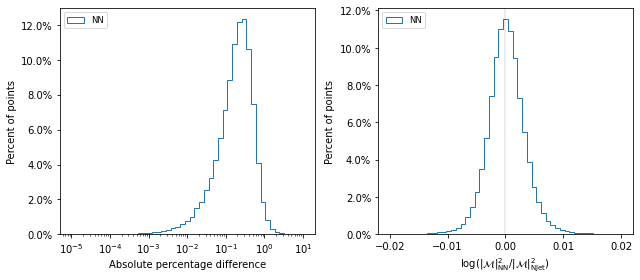

In [25]:
utility_functions.plot_diffs(Y_test, {"NN": y_preds}, bins=np.linspace(-0.02, 0.02, 50));